In [378]:
import random
import time

import numpy as np

from matplotlib import pyplot
from matplotlib.colors import Normalize

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Reshape
import keras


In [379]:
BOARD_SIZE = 10

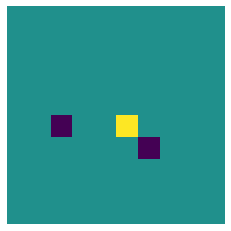

In [380]:
board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))

board[5][5][1] = 1
board[6][6][2] = 1
board[2][5][2] = 1

def vis_board(board, shower=pyplot):
    #pyplot.grid(which='minor', color='w', linestyle='-', linewidth=2)
    shower.imshow((board[:,:,1] - board[:,:,2]).transpose(), norm=Normalize(-1 ,1))
    ax = pyplot.gca()

    ax.set_xticks(np.arange(-.5, BOARD_SIZE, 1), minor=True);
    ax.set_yticks(np.arange(-.5, BOARD_SIZE, 1), minor=True);
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    pyplot.axis('off')


vis_board(board)

In [381]:

move_model = Sequential()
move_model.add(Conv2D(
    64, kernel_size=3, activation='relu', input_shape=(BOARD_SIZE, BOARD_SIZE, 3), padding='same'
))
move_model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
move_model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
move_model.add(Conv2D(1, kernel_size=3, activation='relu', padding='same'))
move_model.add(Flatten())
move_model.add(Softmax())
move_model.add(Reshape((BOARD_SIZE, BOARD_SIZE, 1)))

move_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    #loss='categorical_crossentropy',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

score_model = Sequential()
score_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(BOARD_SIZE, BOARD_SIZE, 3)))#, padding='same'))
score_model.add(Conv2D(64, kernel_size=3, activation='relu')) #, padding='same'))
score_model.add(Conv2D(64, kernel_size=3, activation='relu')) #, padding='same'))

score_model.add(Flatten())

score_model.add(Dense(32, activation='sigmoid'))
score_model.add(Dense(10, activation='sigmoid'))
score_model.add(Dense(1, activation='sigmoid'))

score_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    #loss='categorical_crossentropy',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

move_model.summary()

score_model.summary()


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 10, 10, 64)        1792      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 10, 10, 1)         577       
_________________________________________________________________
flatten_25 (Flatten)         (None, 100)               0         
_________________________________________________________________
softmax_6 (Softmax)          (None, 100)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 10, 1)       

False

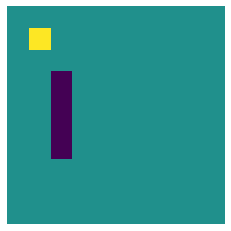

In [319]:
def check_win(board, x, y, player):
    #value = board[x][y][0]
    
    # X direction
    count = 1
    i = 1
    while x - i >= 0 and board[x - i][y][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and board[x + i][y][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Y direction
    count = 1
    i = 1
    while y - i >= 0 and board[x][y - i][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while y + i < BOARD_SIZE and board[x][y + i][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Diagonal 1
    count = 1
    i = 1
    while x - i >= 0 and y - i >= 0 and board[x - i][y - i][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and y + i < BOARD_SIZE and board[x + i][y + i][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Diagonal 2
    count = 1
    i = 1
    while x - i >= 0 and y + i < BOARD_SIZE and board[x - i][y + i][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and y - i >= 0 and board[x + i][y - i][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    return False

board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))

board[2][3][2] = 1
board[2][4][2] = 1
board[2][5][2] = 1
board[2][6][2] = 1
#board[2][7][2] = 1

board[1][1][1] = 1

vis_board(board)

check_win(board, 2, 5, 1)

In [390]:
class RootCalculator():
    def __init__(self):
        self.nodes = 0
    
    def expanded(self):
        self.nodes += 1


class TerminalNode():
    def __init__(self, value, xy):
        self.value = value
        self.best_xy = xy
    
    def do_expansion(self, board):
        pass


class Node():
    def __init__(self, board, root_calculator, xy):
        self.player = int(board[0][0][0])
        #print('Player is here', self.player)
        self.play_positions = []
        self.sub_nodes = []
        self.root_calculator = root_calculator
        self.xy = xy
        self.is_terminal = False
        
        for x in range(BOARD_SIZE):
            for y in range(BOARD_SIZE):
                if board[x][y][1] == 0 and board[x][y][2] == 0:
                    self.play_positions.append((x, y))
        
        if xy == None:
            # Root node
            value = 0.5 # score_model.predict(np.array([board]))[0][0]
        else:
            # Non root
            x, y = xy
            
            board[x][y][self.player + 1] = 1
            if check_win(board, x, y, self.player):
                self.is_terminal = True
                value = self.player
            else:
                value = score_model.predict(np.array([board]))[0][0]
            board[x][y][self.player + 1] = 0            
        
        self.value = value
        self.best_xy = xy
    
    def expand(self, board):
        if self.is_terminal:
            return
        
        best_val = float('inf') if self.player == 0 else float('-inf')
        best_xy = None
        
        for x, y in self.play_positions:            
            sub_node = Node(board, self.root_calculator, (x, y))
            
            self.sub_nodes.append(sub_node)
            
            if (
                (self.player == 1 and sub_node.value > best_val) or
                (self.player == 0 and sub_node.value < best_val)
            ):
                best_val = sub_node.value
                best_xy = (x, y)
            
        self.value = best_val
        self.best_xy = best_xy
    
    def do_expansion(self, board):
        self.root_calculator.expanded()
        
        # Set board
        if self.xy != None:
            x, y = self.xy
            board[x][y][self.player + 1] = 1
            board[:,:,0] = self.player
        
        if self.sub_nodes:
            
            random_node = random.choice(self.sub_nodes)
            
            raise NotImplemented()
            
            random_node.do_expansion(board)
            
            if self.player == 1:
                if random_node.value > self.value:
                    self.best_xy = random_node.best_xy
                self.value = max(random_node.value, self.value)
            else:
                if random_node.value < self.value:
                    self.best_xy = random_node.best_xy
                self.value = min(random_node.value, self.value)
        else:
            self.expand(board)

        # Unset board
        if self.xy != None:
            board[x][y][self.player + 1] = 0
            board[:,:,0] = self.player
            

def choose_play(board):
    pass

board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))


start_time = time.time()


boards = []
plays = []
board_statuses = []

while True:
    batch_boards = []
    batch_plays = []
    batch_board_stauts = []
    
    board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))
    
    for i in range(BOARD_SIZE * BOARD_SIZE / 2): # Max board size / 2 so no stupid board filling games allowed
        #print('Starting loop')
        cur_player = int(board[0][0][0])

        root_calculator = RootCalculator()
        node = Node(board, root_calculator, None)
        for i in range(250):
            node.do_expansion(board)
            #print('node_count', root_calculator.nodes)

        x, y = node.best_xy

        batch_boards.append(board.copy())
        play_pos = np.zeros((BOARD_SIZE, BOARD_SIZE, 1))
        play_pos[x][y][0] = 1
        batch_plays.append(play_pos)

        board[x][y][cur_player + 1] = 1

        if check_win(board, x, y, cur_player):
            #print('Win condition found')
            batch_board_stauts = len(batch_boards) * [cur_player]
            break

        board[:,:,0] = 1 if cur_player == 0 else 0 # Change the current player

    boards += batch_boards
    plays += batch_plays
    board_statuses += batch_board_stauts
    
    print('Win happened', len(boards), len(plays), len(board_statuses))

        
#print('Value', node.value)
#print('Best xy', node.best_xy)
#print('Time (s)', time.time() - start_time)

vis_board(board)

TypeError: 'float' object cannot be interpreted as an integer

In [321]:
i = 0

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


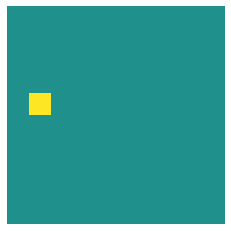

In [323]:
print(plays[i].reshape(BOARD_SIZE,BOARD_SIZE))
i += 1
vis_board(boards[i])

In [324]:
len(plays), len(batch_boards), len(batch_board_stauts)

(2, 2, 0)

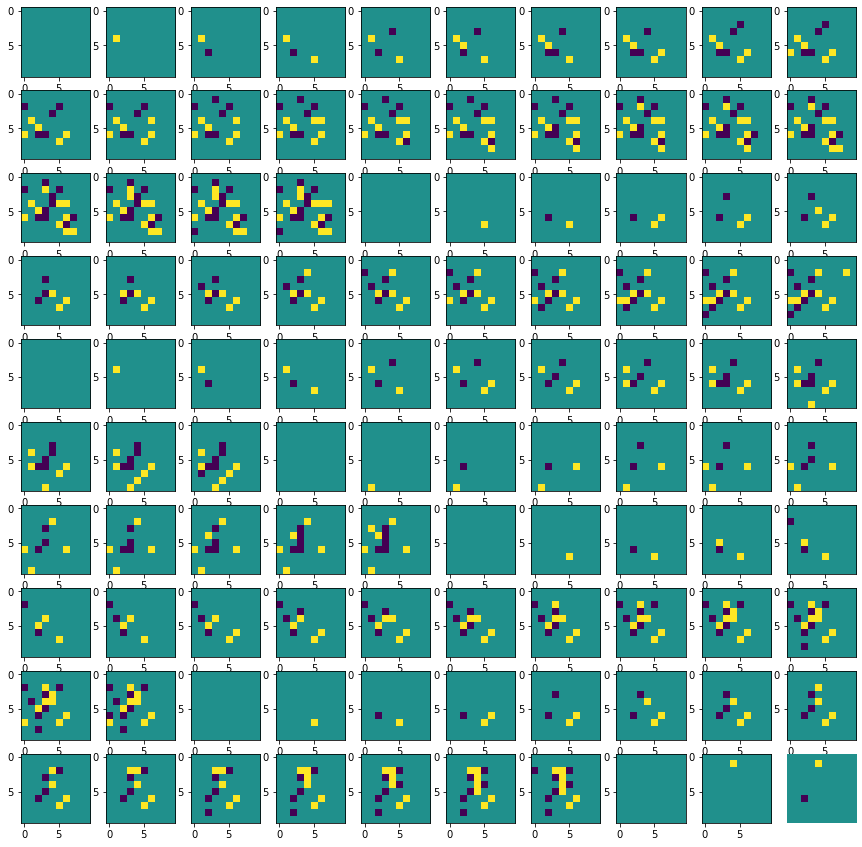

In [339]:
fig, axs = pyplot.subplots(10, 10, figsize=(15, 15))
i = 0
for x in range(10):
    for y in range(10):
        vis_board(boards[i], axs[x][y])
        i += 1

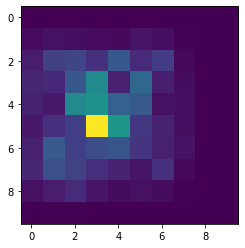

In [389]:
prediction = move_model.predict(np.array([boards[11]])).reshape(BOARD_SIZE, BOARD_SIZE)


pyplot.imshow(
    prediction.transpose(),
    norm=Normalize(0, 0.1)
)

In [382]:
history = score_model.fit(
    np.array(boards),
    np.array(board_statuses),
    epochs=20,
    validation_split=0.2,
    shuffle=True
)

Train on 314 samples, validate on 79 samples
Epoch 1/20
314/314 [==============================] - 0s 1ms/step - loss: 0.7133 - accuracy: 0.4586 - val_loss: 0.6998 - val_accuracy: 0.5063
Epoch 2/20
314/314 [==============================] - 0s 508us/step - loss: 0.7107 - accuracy: 0.4586 - val_loss: 0.6982 - val_accuracy: 0.5063
Epoch 3/20
314/314 [==============================] - 0s 513us/step - loss: 0.7072 - accuracy: 0.4586 - val_loss: 0.6967 - val_accuracy: 0.5063
Epoch 4/20
314/314 [==============================] - 0s 494us/step - loss: 0.7036 - accuracy: 0.4586 - val_loss: 0.6953 - val_accuracy: 0.5063
Epoch 5/20
314/314 [==============================] - 0s 507us/step - loss: 0.6997 - accuracy: 0.4586 - val_loss: 0.6943 - val_accuracy: 0.5063
Epoch 6/20
314/314 [==============================] - 0s 533us/step - loss: 0.6960 - accuracy: 0.4713 - val_loss: 0.6942 - val_accuracy: 0.4810
Epoch 7/20
314/314 [==============================] - 0s 490us/step - loss: 0.6932 - accuracy

In [385]:
history = move_model.fit(
    np.array(boards),
    np.array(plays),
    epochs=20,
    validation_split=0.2,
    shuffle=True
)

Train on 314 samples, validate on 79 samples
Epoch 1/20
314/314 [==============================] - 1s 2ms/step - loss: 0.0558 - accuracy: 0.9900 - val_loss: 0.0555 - val_accuracy: 0.9900
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 0.0554 - accuracy: 0.9900 - val_loss: 0.0551 - val_accuracy: 0.9900
Epoch 3/20
314/314 [==============================] - 0s 1ms/step - loss: 0.0550 - accuracy: 0.9900 - val_loss: 0.0547 - val_accuracy: 0.9900
Epoch 4/20
314/314 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9900 - val_loss: 0.0541 - val_accuracy: 0.9900
Epoch 5/20
314/314 [==============================] - 0s 1ms/step - loss: 0.0539 - accuracy: 0.9900 - val_loss: 0.0533 - val_accuracy: 0.9900
Epoch 6/20
314/314 [==============================] - 0s 1ms/step - loss: 0.0532 - accuracy: 0.9900 - val_loss: 0.0526 - val_accuracy: 0.9900
Epoch 7/20
314/314 [==============================] - 0s 1ms/step - loss: 0.0525 - accuracy: 0.9900 - v

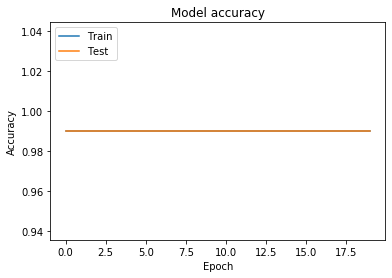

In [386]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Model accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.show()

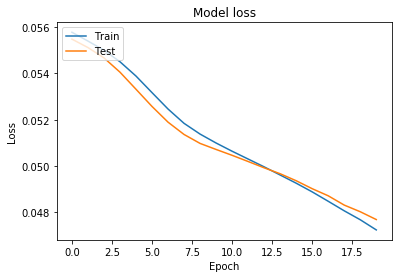

In [387]:
# Plot training & validation loss values
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.show()
